## Importing Packages

In [1]:
# Importing (using/include) packages and files needed for the code to run 
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics 
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")
include("GridOperations.jl")

# Note: that we import pyplot last to avoid a name conflict with grid
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Topography Setup

In [9]:
# The initial topography setup follows the following:
# y = A*sin[k(x-b)]+c 
# |A| is the amplitude 
# k is the wave number (k=2π/wavelength)
# The period is 2π/k 
# The horizontal shift is b 
# The vertical shift is c 


function initial_ice_depth(x::Float64)
    w = 90000.0
    w2 = 10000.0 
    w3 = 100000.0
    w4 = 200000.0
    w5 = 300000.0
    A = 0.1*90000.0
    k = (2*pi)/w
    b = 0.0
    c = 0.5*90000.0
    return (A)*(sin(k*(x-b)))+(c)
end

function initial_surface_depth(x::Float64)
     return 3e4
end

function ice_viscosity(T::Float64)
    Q = 40000.0 # Activation Enegry
    R_cont = 8.314 # Gas Constant 
    return (1e15)*exp((Q*(273.0-T))/(R_cont*(273.0*T)))
end


# # Creating a function to assign viscosity if eta is not constant
# function compute_variable_eta(markers::Markers,materials::Materials)
#     t_icy = zeros(1,markers.nmark)
#     eta_i = zeros(1,markers.nmark)
#     for i in 1:markers.nmark
#         mx = markers.x[1,i]
#         my = markers.x[2,i]
#         h = initial_ice_depth(mx)
#         hsurf = initial_surface_depth(mx)
#         if my < h
#             t_icy[i] = 100.0+((273.0-100.0)/(h-hsurf))*(my-hsurf)
#             eta_i[i] = (1e15)*exp((Q*(273.0-t_icy[i]))/(R_cont*(273.0*t_icy[i])))
#         end
#     end 
#     return t_icy,eta_i
# end


ice_viscosity (generic function with 1 method)

# Material Setup

In [10]:
struct Materials
    # 1 - subsurface global ocean
    # 2 - icy shell
    # 3 - sticky air
    alpha::Vector{Float64}
    rho0::Vector{Float64}
    Hr::Vector{Float64}
    Cp::Vector{Float64}
    kThermal::Vector{Float64}
    eta::Vector{Float64}
    function Materials()
        new([0.0,0.0,0.0],[1000.0,920.0,1.0],[0.0,0.0,0.0],[4180.0,2100,1e6],[0.5610,2.22,0.024],[1e12,1e15,1e17])
    end    
end

function update_marker_viscosity!(markers::Markers,materials::Materials)
    eta = markers.scalarFields["eta"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        if mmat[i] == 2
            markers.scalars[eta,i] = ice_viscosity( markers.scalars[T,i] )
        end
    end
end


function update_marker_density!(markers::Markers,materials::Materials)
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark                
        markers.scalars[rho,i] = materials.rho0[mmat[i]]
    end
end


function initial_conditions!(markers::Markers,materials::Materials)
    material = markers.integerFields["material"]
    T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    alpha = markers.scalarFields["alpha"]
    Cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        hice = initial_ice_depth(mx)
        hsurf = initial_surface_depth(mx)
        if my > hice
            # subsurface global ocean
            markers.integers[material,i] = 1
            markers.scalars[T,i] = 273.0
            markers.scalars[eta,i] = materials.eta[1]
            markers.scalars[alpha,i] = materials.alpha[1]        
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1]  
        elseif my > hsurf
            # icy shell
            markers.integers[material,i] = 2
            markers.scalars[T,i] = 100.0+((273.0-100.0)/(hice-hsurf))*(my-hsurf)
            # markers.scalars[eta,i] = eta_i[i]
            markers.scalars[alpha,i] = materials.alpha[2]
            markers.scalars[Cp,i] = materials.Cp[2]
            markers.scalars[Hr,i] = materials.Hr[2]  
        else
            # sticky air
            markers.integers[material,i] = 3
            markers.scalars[T,i] = 100.0            
            markers.scalars[eta,i] = materials.eta[3]
            markers.scalars[alpha,i] = materials.alpha[3]  
            markers.scalars[Cp,i] = materials.Cp[3]
            #markers.scalars[Hr,i] = materials.Hr[3] 
        end
    end 
    # end loop over markers
    update_marker_viscosity!(markers,materials)
    update_marker_density!(markers,materials)
end

initial_conditions! (generic function with 1 method)

# Model Setup

Creating Markers...
  0.010403 seconds (21 allocations: 33.784 MiB)
Initial condition...
  0.094129 seconds (1.56 M allocations: 25.429 MiB, 10.34% gc time)
Finished Step 1 time=0.00016331099879057507 Myr
Finished Step 2 time=0.0003378778036807958 Myr
Finished Step 3 time=0.0005059045442088279 Myr
Finished Step 4 time=0.0006746697482493497 Myr
Finished Step 5 time=0.0008452122221441869 Myr
Finished Step 6 time=0.0010144483609801644 Myr
Finished Step 7 time=0.0011854943734723254 Myr
Finished Step 8 time=0.0013676732691402776 Myr
Finished Step 9 time=0.001558604476311437 Myr
Finished Step 10 time=0.0017555508279854656 Myr
Finished Step 11 time=0.001960292239490642 Myr
Finished Step 12 time=0.002188282169871717 Myr
Finished Step 13 time=0.002418417847735953 Myr
Finished Step 14 time=0.0026506765839830015 Myr
Finished Step 15 time=0.002884987932444251 Myr
Finished Step 16 time=0.0031209201143932493 Myr
Finished Step 17 time=0.00335790303075552 Myr
Finished Step 18 time=0.003596660497518354

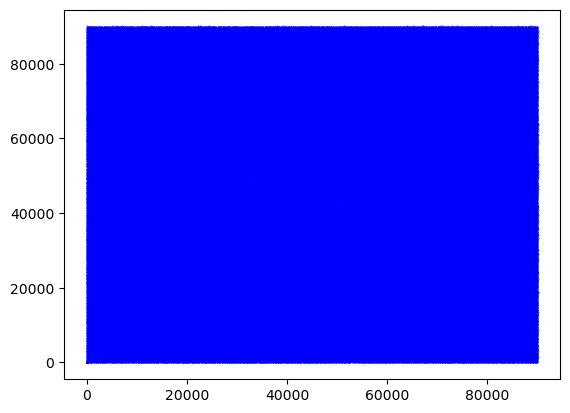

In [11]:
# function run(nstep::Int64)
    nstep=30
    nx = 101
    ny = 101
    W = 90000.0
    H = 90000.0
    gx = 0.0
    gy = 1.3
   
    
    Tbctype = [-1,-1,1,1] #left, right, top, bottom
    Tbcval = [0.0,0.0,100.0,273.0] #left, right, top, bottom
    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    materials = Materials()
    
    markx = 6
    marky = 6
    seconds_in_year = 3.15e7
    plot_interval = 1e6*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["alpha","T","rho","eta","Cp","Hr"],["material"] ; nmx=markx,nmy=marky,random=true)
    println("Initial condition...")
    @time initial_conditions!(markers, materials)


    # Setting up inital model schematic
    i_air_ice_interface = zeros(Float64,grid.nx+1)
    i_ocean_ice_interface = zeros(Float64,grid.nx+1)
    # Transfer materials to nodes
    i_mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")
    function get_i_interface(grid::CartesianGrid,mat,contour_value)
        i_interface_position = zeros(Float64,grid.nx+1);
        for j in 1:grid.nx+1
            i = 1
            while i <= grid.ny
                if i_mat[i,j] == contour_value
                    i_interface_position[j] = grid.yc[j]
                    break
                elseif i_mat[i+1,j] < contour_value
                    # interface is located within this cell.
                    i_interface_position[j] = grid.yc[i] + (grid.yc[i+1]-grid.yc[i])/(i_mat[i+1,j]-i_mat[i,j])*(contour_value-i_mat[i,j])
                    break
                end
                i = i+1
            end
        end
        return i_interface_position
    end
    i_air_ice_interface = get_i_interface(grid,i_mat,2.5)
    i_ocean_ice_interface = get_i_interface(grid,i_mat,1.5)

#     figure()
#     pcolor(grid.xc,grid.yc,mat)
#     colorbar()
#     plot(grid.xc,i_air_ice_interface,"k",label="air-ice interface")
#     plot(grid.xc,i_ocean_ice_interface,"r",label="ocean-ice interface")
#     title(L"Initial\,\,Model\,\,Schematic")
#     gca().invert_yaxis()
#     gca().set_aspect("equal")
#     gca().set_ylabel(L"Height\,(m)")
#     gca().set_xlabel(L"Width\,(m)")
#     legend()
#     show()

#     figure()
#     plot(grid.xc,i_ocean_ice_interface-i_air_ice_interface)
#     title(L"Initial\,\,Ice\,\,Shell\,\,Thickness\,\,Across\,\,the\,\,Horizontal\,\,Direction")
#     gca().set_ylabel(L"thickness\,(m)")
#     gca().set_xlabel(L"x\,(m)")
#     show()


    # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
    kThermal = 3.0 .*ones(grid.ny,grid.nx);
    
    time = 0.0
    iout=0
    last_plot = 0.0
    rho_c = nothing
    eta_s = nothing
    Hr = nothing
    Cp_c = nothing
    alpha = nothing
    eta_n = nothing
    Tlast = nothing
    rho_vx = nothing 
    rho_vy = nothing
    vxc = nothing 
    vyc = nothing
    Tnew = nothing
    dt = 1e10

#     local rho_c 
#     local rho_vx
#     local rho_vy
#     local alpha
#     local Hr
#     local Cp_c
#     local eta_s
#     local eta_n
#     local vxc
#     local vyc
#     local T
#     local dt
#     local dTmax
#     local dTemp
#     local Tnew
#     local Tlast

    output_dir = "test"
    for itime in 1:nstep
        # 0. update the viscosity and the density on the markers
        update_marker_viscosity!(markers,materials)
        # 1. Transfer properties markers -> nodes
        # 1a. Basic Nodes
        eta_s_new, = marker_to_stag(markers,grid,["eta",],"basic");
        # 1b. Cell Centers
        rho_c_new,Cp_c_new,alpha_new,eta_n_new,Tlast_new,Hr_new = marker_to_stag(markers,grid,["rho","Cp","alpha","eta","T","Hr"],"center")
        # 1c. Vx and Vy nodes:
        rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
        rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy") 
       
        # deal with any NaN values from interpolation:
        if itime > 1
            if any(isnan.(eta_s_new))
                println("found nan values")
            end
            replace_nan!(eta_s,eta_s_new)
            replace_nan!(rho_c,rho_c_new)
            replace_nan!(Hr,Hr_new)
            replace_nan!(Cp_c,Cp_c_new)
            replace_nan!(alpha,alpha_new)
            replace_nan!(eta_n,eta_n_new)
            replace_nan!(Tlast,Tlast_new)
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
        end
        # Copy field data 
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)
        rho_c = copy(rho_c_new)
        Hr = copy(Hr_new)
        Cp_c = copy(Cp_c_new)
        alpha = copy(alpha_new)
        eta_s = copy(eta_s_new)
        eta_n = copy(eta_n_new)
        Tlast = copy(Tlast_new)

        # 2. Assemble and solve the stokes equations
        L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy;dt=dt)
        stokes_solution = L\R
        vx,vy,P = unpack(stokes_solution,grid;ghost=true)
    
        # Get the velocity at the cell centers:
        vxc,vyc = velocity_to_centers(grid,vx,vy)
        adiabatic_heating = compute_adiabatic_heating(grid,rho_c,Tlast,alpha,gx,gy,vxc,vyc)
        shear_heating = compute_shear_heating(grid,vx,vy,eta_n,eta_s)
        H = (adiabatic_heating .+ shear_heating .+ Hr)
    
    
        # 3. Compute the advection timestep:
        if itime > 1
            this_dtmax = min(1.2*dt,dtmax)
        else
            this_dtmax = dtmax
        end
        dt = compute_timestep(grid,vxc,vyc ; dtmax=this_dtmax)

        dTmax = Inf
        dTemp = nothing
        Tnew = nothing
        titer = 1
        for titer=1:2
            # assemble and solve the energy equation
#             println("Trying with timestep ",dt)
            L,R = assemble_energy_equation_center(grid,rho_c,Cp_c,kThermal,H,Tlast,dt,Tbcval);
            Tnew = L\R;
            Tnew = reshape(Tnew,grid.ny,grid.nx);
            Tnew = ghost_temperature_center(grid,Tnew,Tbctype,Tbcval);

            T = copy(Tnew)

            dTemp = Tnew-Tlast
            # compute the maximum temperature change
            dTmax = maximum(abs.(dTemp))
            
#             println("dTmax=",dTmax," dt=",dt/3.15e7/1e6)
            dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)
            if dTmax < 10.0
                break
            end
        end

        dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,Tlast,Cp_c[1,1],kThermal[1,1],dt)
        dT_remaining = dTemp - dT_subgrid_node
    
        cell_center_change_to_markers!(markers,grid,dT_remaining,"T")

#         if time == 0.0 || time - last_plot >= plot_interval
#             last_plot = time 
#             name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
#             vn = velocity_to_basic_nodes(grid,vxc,vyc)

#         visualization(grid,rho_c,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name)
#             name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
#             visualization(markers,time/seconds_in_year;filename=name)
#             iout += 1
#         end

        
#         println("Min/Max velocity: ",minimum(vyc)," ",maximum(vyc))
        move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=1/3)
        time += dt
        println("Finished Step ",itime," time=",time/seconds_in_year/1e6," Myr")
    end
    return grid,markers,vxc,vyc,rho_c,eta_n,Tnew,time
# end 
# @time grid,markers,vxc,vyc,rho_c,eta_n,Tnew,time = run(1)


figure()
scatter(markers.x[1,:],markers.x[2,:],c="b",s=0.1)
show()

# Initial Model Schematic and Profiles

The maximum total initial thickness of the icy shell is 24(km)
The average initial thickness of the icy shell is 15(km)
The initial amplitude is 9(km)

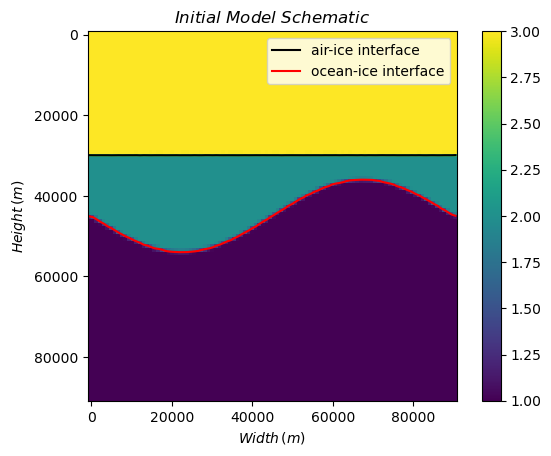

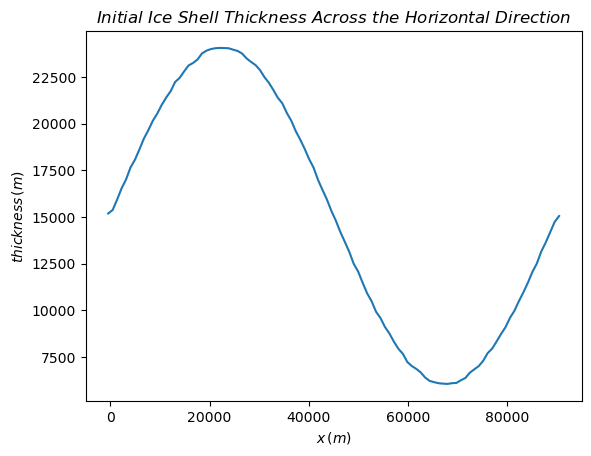

In [13]:
figure()
pcolor(grid.xc,grid.yc,i_mat)
colorbar()
plot(grid.xc,i_air_ice_interface,"k",label="air-ice interface")
plot(grid.xc,i_ocean_ice_interface,"r",label="ocean-ice interface")
title(L"Initial\,\,Model\,\,Schematic")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
legend()
show()

figure()
plot(grid.xc,i_ocean_ice_interface-i_air_ice_interface)
title(L"Initial\,\,Ice\,\,Shell\,\,Thickness\,\,Across\,\,the\,\,Horizontal\,\,Direction")
gca().set_ylabel(L"thickness\,(m)")
gca().set_xlabel(L"x\,(m)")
show()

println("The maximum total initial thickness of the icy shell is ",@sprintf("%.2g",maximum(i_ocean_ice_interface-i_air_ice_interface)/1000),"(km)")
i_ice_avg = mean(i_ocean_ice_interface-i_air_ice_interface)
println("The average initial thickness of the icy shell is ",@sprintf("%.2g",i_ice_avg/1000),"(km)")
i_amp = (maximum(i_ocean_ice_interface-i_air_ice_interface)-i_ice_avg)
print("The initial amplitude is ",@sprintf("%.2g",i_amp/1000),"(km)")


# Model Schematic After x Runs 

The maximum total thickness of the icy shell after 0.0066 Myr is 21(km)
The average thickness of the icy shell after 0.0066 Myr is 15(km)
The amplitude after 0.0066 Myr is 6.3(km)

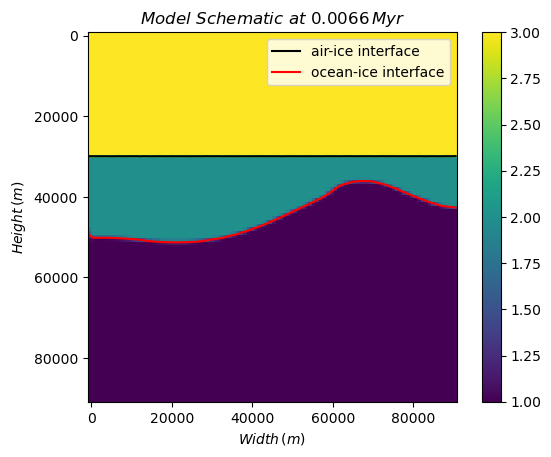

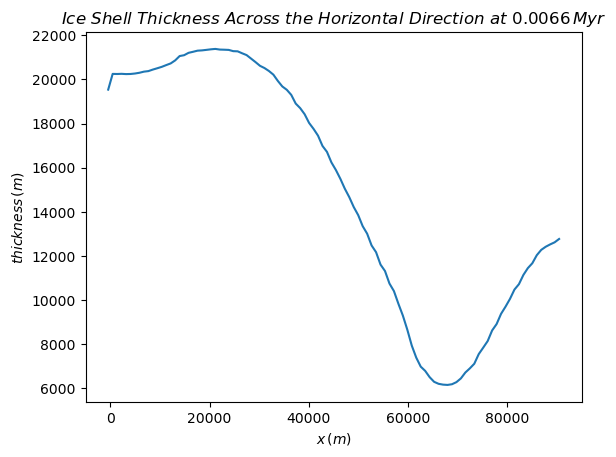

In [14]:
air_ice_interface = zeros(Float64,grid.nx+1)
ocean_ice_interface = zeros(Float64,grid.nx+1)

# Transfer materials to nodes
mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")

function get_interface(grid::CartesianGrid,mat,contour_value)
    interface_position = zeros(Float64,grid.nx+1);
    for j in 1:grid.nx+1
        i = 1
        while i <= grid.ny
            if mat[i,j] == contour_value
                interface_position[j] = grid.yc[i]
                break
        elseif mat[i+1,j] < contour_value
                # interface is located within this cell.
                interface_position[j] = grid.yc[i] + (grid.yc[i+1]-grid.yc[i])/(mat[i+1,j]-mat[i,j])*(contour_value-mat[i,j])
                break
            end
            i = i+1
        end
    end
    return interface_position
end
ocean_ice_interface = get_interface(grid,mat,1.5)
air_ice_interface = get_interface(grid,mat,2.5)

x_time = @sprintf("%.2g",time/3.15e7/1e6)
figure()
pcolor(grid.xc,grid.yc,mat)
colorbar()
plot(grid.xc,air_ice_interface,"k",label="air-ice interface")
plot(grid.xc,ocean_ice_interface,"r",label="ocean-ice interface")
title(L"Model\,\,Schematic\,\,at\,\,%$x_time\,Myr")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
legend()
show()

figure()
plot(grid.xc,ocean_ice_interface-air_ice_interface)
title(L"Ice\,\,Shell\,\,Thickness\,\,Across\,\,the\,\,Horizontal\,\,Direction\,\,at\,\,%$x_time\,Myr")
gca().set_ylabel(L"thickness\,(m)")
gca().set_xlabel(L"x\,(m)")
show()

println("The maximum total thickness of the icy shell after $x_time Myr is ",@sprintf("%.2g",maximum(ocean_ice_interface-air_ice_interface)/1000),"(km)")
ice_avg = mean(ocean_ice_interface-air_ice_interface)
println("The average thickness of the icy shell after $x_time Myr is ",@sprintf("%.2g",ice_avg/1000),"(km)")
amp = (maximum(ocean_ice_interface-air_ice_interface)-ice_avg)
print("The amplitude after $x_time Myr is ",@sprintf("%.2g",amp/1000),"(km)")

# Plot of Profiles After x Runs

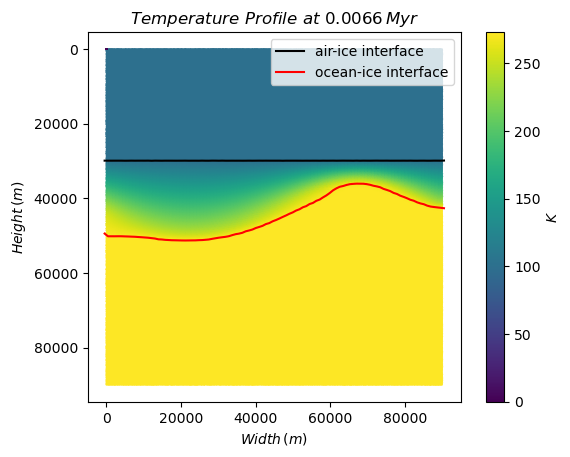

sys:1: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


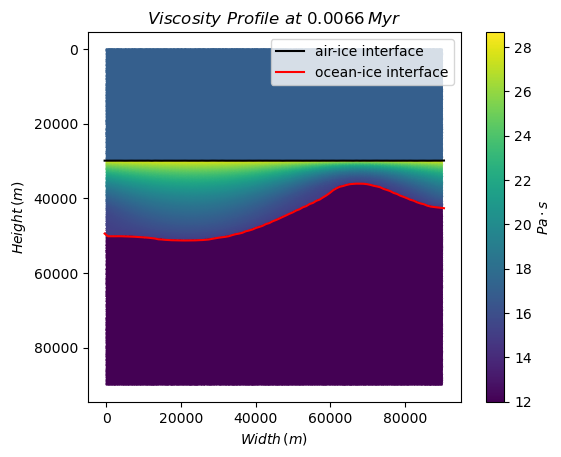

In [15]:
# Temperature Profile 
figure()
scatter(markers.x[1,:],markers.x[2,:],c=markers.scalars[markers.scalarFields["T"],:],s=0.1)
plot(grid.xc,air_ice_interface,"k",label="air-ice interface")
plot(grid.xc,ocean_ice_interface,"r",label="ocean-ice interface")
title(L"Temperature\,\,Profile\,\,at\,\,%$x_time\,Myr")
colorbar(label=L"K")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
legend()
show()

# Viscosity Profile 
figure()
scatter(markers.x[1,:],markers.x[2,:],c=log10.(markers.scalars[markers.scalarFields["eta"],:]),s=0.1)
plot(grid.xc,air_ice_interface,"k",label="air-ice interface")
plot(grid.xc,ocean_ice_interface,"r",label="ocean-ice interface")
title(L"Viscosity\,\,Profile\,\,at\,\,%$x_time\,Myr")
colorbar(label=L"Pa\cdot{s}")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
legend()
show()


0.0184(Myr)

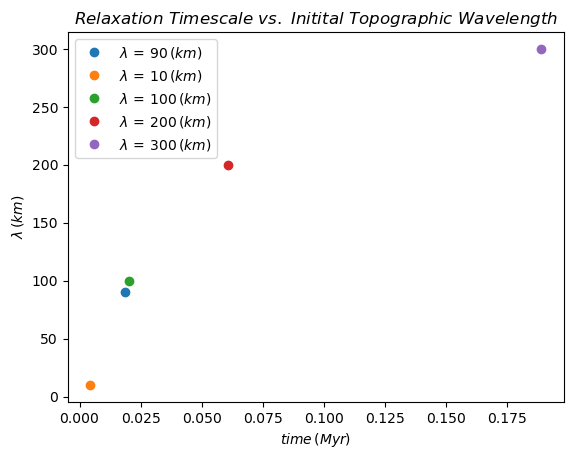

In [22]:
# 1. Ran 5 numerical experiments for 30 timesteps at nx = 101 and ny = 101 and wavelengths were 90km,10km,100km,200km,300km 
# 2. Ran 5 numerical experiments for 30 timesteps at nx = 201 and ny = 201 and wavelengths were 90km,10km,100km,200km,300km 

t = time/3.15e7/1e6 # Myr
tr = -(t)/log(amp/i_amp)
print(@sprintf("%.3g",tr),"(Myr)")

# 1. 
# [experiment_1,experiment_2,experiment_3,experiment_4,experiment_5]
x_tr = 0.0184 # units of Myr
x_tr1 = 0.00446
x_tr2 = 0.0202
x_tr3 = 0.0609
x_tr4 = 0.189

y_w = 90 # units of km 
y_w1 = 10
y_w2 = 100
y_w3 = 200
y_w4 = 300 

figure()
plot(x_tr,y_w,"o",label=L"\lambda\,=\,90\,(km)")
plot(x_tr1,y_w1,"o",label=L"\lambda\,=\,10\,(km)")
plot(x_tr2,y_w2,"o",label=L"\lambda\,=\,100\,(km)")
plot(x_tr3,y_w3,"o",label=L"\lambda\,=\,200\,(km)")
plot(x_tr4,y_w4,"o",label=L"\lambda\,=\,300\,(km)")
gca().set_ylabel(L"\lambda\,(km)")
gca().set_xlabel(L"time\,(Myr)")
title(L"Relaxation\,\,Timescale\,\,vs.\,\,Initital\,\,Topographic\,\,Wavelength")
legend()
show()


# 2. 


# Printing Values 

In [20]:
# print("Creating eta at cell center matrix...")
# @time display(eta_n)
# print("Creating vx matrix...")
# @time display(vxc)
# print("Creating vy matrix...")
# @time display(vyc)
# print("Creating rho matrix...")
# @time display(rho_c)

0.006560134012324086